In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

# Dataset

In [2]:
df = pd.read_csv('mod_data_name_end_only.csv')
df

name  endorsement_count  \
0      Alexi CirTein a Stormcloak officer - A followe...                184   
1                             Ravien - Queen of the Bolt                196   
2              Nocturnals Craftable Armor -CBBE friendly               1295   
3                                     Solitude Expansion               4545   
4              Gradually Restorative Potions- Standalone                108   
...                                                  ...                ...   
30133              Luna - A Standalone Follower (ESP-FE)                 61   
30134  Anabella - High Poly Standalone Tank Follower ...                300   
30135                          Buoyant Armiger Armors SE                  1   
30136   Follow Me Darling - All Spouses Can Be Followers                 63   
30137                   aMidianBorn Content Addon SSE RU                  8   

       high  
0         1  
1         1  
2         1  
3         1  
4         1  
...     ...  
30133     0  
30134     1  
30135     0  
30136     0  
30137     0  

[30138 rows x 3 columns]

View some information regarding the dataset

In [3]:
df.groupby('high').describe()

endorsement_count                                                        \
                 count         mean          std    min    25%    50%    75%   
high                                                                           
0              16662.0    33.416937    27.181438    0.0   10.0   26.0   52.0   
1              13476.0  1474.652939  6233.144846  100.0  167.0  320.0  855.0   

                
           max  
high            
0         99.0  
1     223850.0

In [4]:
df['high'].value_counts()

0    16662
1    13476
Name: high, dtype: int64

## Treating Outliers
Mods that have more than 1000 endorsements will be considered as outliers

In [5]:
df_filtered = df.drop(df[(df['endorsement_count'] > 1000) | (df['endorsement_count'] < 5)].index)
df_filtered['high'].value_counts()

0    14761
1    10489
Name: high, dtype: int64

## Train-test Split

In [18]:
seed = 69420

df_main = df_filtered

y = df_main['high']
x = df_main.drop(['high', 'endorsement_count'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=df_main['high'], random_state=seed)

x_train.head()

name
14104                   Conjurable Beds
8076      Project Eclipse 1 Auriels Bow
9356                    Kneel Before Me
23431            Chinese Han Sword - SE
19023  moreHUD SE - Traduzione Italiana

# DNN

## Model Setup

In [7]:
preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

bert_preprocess = hub.KerasLayer(preprocess_url)
bert_encoder = hub.KerasLayer(encoder_url)

In [8]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural Network layers
l = tf.keras.layers.Dropout(0.1, name='dropout') (outputs['pooled_output'])
l = tf.keras.layers.Dense(256, activation='relu') (l)
l = tf.keras.layers.Dropout(0.1, name='dropout2') (l)
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

# Construct final model
model = tf.keras.Model(inputs=[text_input], outputs=[l])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

## Training

In [9]:
def train(
    model, 
    x,
    y, 
    val_split=0.2, 
    model_name:str = 'model',
    use_early_stopping:bool = True,
    use_tensorboard_callback:bool = True,
    tensorboard_path:str = './tensorboard_logs/',
    use_model_checkpoint:bool = False,
    use_csv_logger:bool = True,
    csv_path:str = './csv_logs/',
    checkpoint_freq:int = 1,
    checkpoint_path:str = './model_checkpoints/',
    epochs:int = 10, 
    verbose:int = 2,
    append_csv:bool= False,
    initial_epoch = 0,
):

    # Create callbacks
    callbacks:list = []

    # Tensorboard
    if (use_tensorboard_callback):
        log_dir = tensorboard_path + model_name
        tensorboard_callback = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir, 
            histogram_freq=1,
            embeddings_freq=1,
            write_images=False,
        )
        callbacks.append(tensorboard_callback)
    # Early stopping
    if (use_early_stopping):
        early_stopping_callback = tf.keras.callbacks.EarlyStopping(
            # Stop training when `val_loss` is no longer improving
            monitor="val_loss",
            # "no longer improving" being defined as "no better than 1e-2 less"
            min_delta=1e-2,
            # "no longer improving" being further defined as "for at least 5 epochs"
            patience=5,
            verbose=1
        )
        callbacks.append(early_stopping_callback)
    # Model checkpoints
    if (use_model_checkpoint):
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            # Path where to save the model
            # The two parameters below mean that we will overwrite
            # the current checkpoint if and only if
            # the `loss` score has improved.
            # The saved model name will include the current epoch.
            filepath = checkpoint_path + model_name + '/',
            save_best_only=True,  # Only save a model if `val_loss` has improved.
            monitor="loss", 
            verbose=0,
            save_weights_only=True,
            save_freq = checkpoint_freq
        )
        callbacks.append(model_checkpoint_callback)
    # CSV Logger
    if (use_csv_logger):
        csv_logger = tf.keras.callbacks.CSVLogger(
            csv_path + model_name + '.csv',
            append=append_csv
        )
        callbacks.append(csv_logger)
    
    # Train the model
    print('Begin training model...')
    return model.fit(
        x,
        y,
        validation_split = val_split,
        epochs = epochs,
        callbacks = callbacks,
        verbose = verbose,
        initial_epoch = initial_epoch
    )

In [10]:
model_name = 'name_bert_large_model'
graph_save_location = f'./model_checkpoints/{model_name}/{model_name}.png'
csv_path:str = f'./model_checkpoints/{model_name}/'
tensorboard_path:str = './model_checkpoints/tensorboard_logs/'
checkpoint_path:str = './model_checkpoints/'
use_tensorboard_callback = False
append_csv = True
val_split= 0.2
epochs = 50
test_predict_text = 'Sigil Stone Fix'     # Used to test singular input in the model
# weight_path = f'model_checkpoints/{model_name}/'        # Path to previous trained weights. Leave as empty string to not use this feature
weight_path = ''

# Load weights
if (append_csv and weight_path != ''):
    model.load_weights(weight_path)

# Training metrics
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=METRICS
)

history = train(
        model, 
        x_train,
        y_train ,
        val_split=val_split, 
        use_tensorboard_callback=use_tensorboard_callback,
        model_name=model_name, 
        use_model_checkpoint=True,
        verbose=1,
        epochs=epochs,
        append_csv=append_csv,
        csv_path = csv_path,
        tensorboard_path = tensorboard_path,
        checkpoint_path = checkpoint_path,
    )

Begin training model...
Epoch 1/50
442/442 [==============================] - 1031s 2s/step - loss: 0.6959 - accuracy: 0.5596 - precision: 0.4375 - recall: 0.2059 - val_loss: 0.6757 - val_accuracy: 0.5822 - val_precision: 0.4902 - val_recall: 0.2738
Epoch 2/50
442/442 [==============================] - 281s 628ms/step - loss: 0.6774 - accuracy: 0.5735 - precision: 0.4676 - recall: 0.1840 - val_loss: 0.6671 - val_accuracy: 0.5867 - val_precision: 0.5000 - val_recall: 0.0390
Epoch 3/50
442/442 [==============================] - 195s 433ms/step - loss: 0.6732 - accuracy: 0.5806 - precision: 0.4896 - recall: 0.2008 - val_loss: 0.6657 - val_accuracy: 0.5963 - val_precision: 0.6012 - val_recall: 0.0691
Epoch 4/50
442/442 [==============================] - 195s 433ms/step - loss: 0.6687 - accuracy: 0.5891 - precision: 0.5153 - recall: 0.2032 - val_loss: 0.6628 - val_accuracy: 0.5915 - val_precision: 0.5423 - val_recall: 0.0746
Epoch 5/50
442/442 [==============================] - 191s 432ms/s

Graph training session

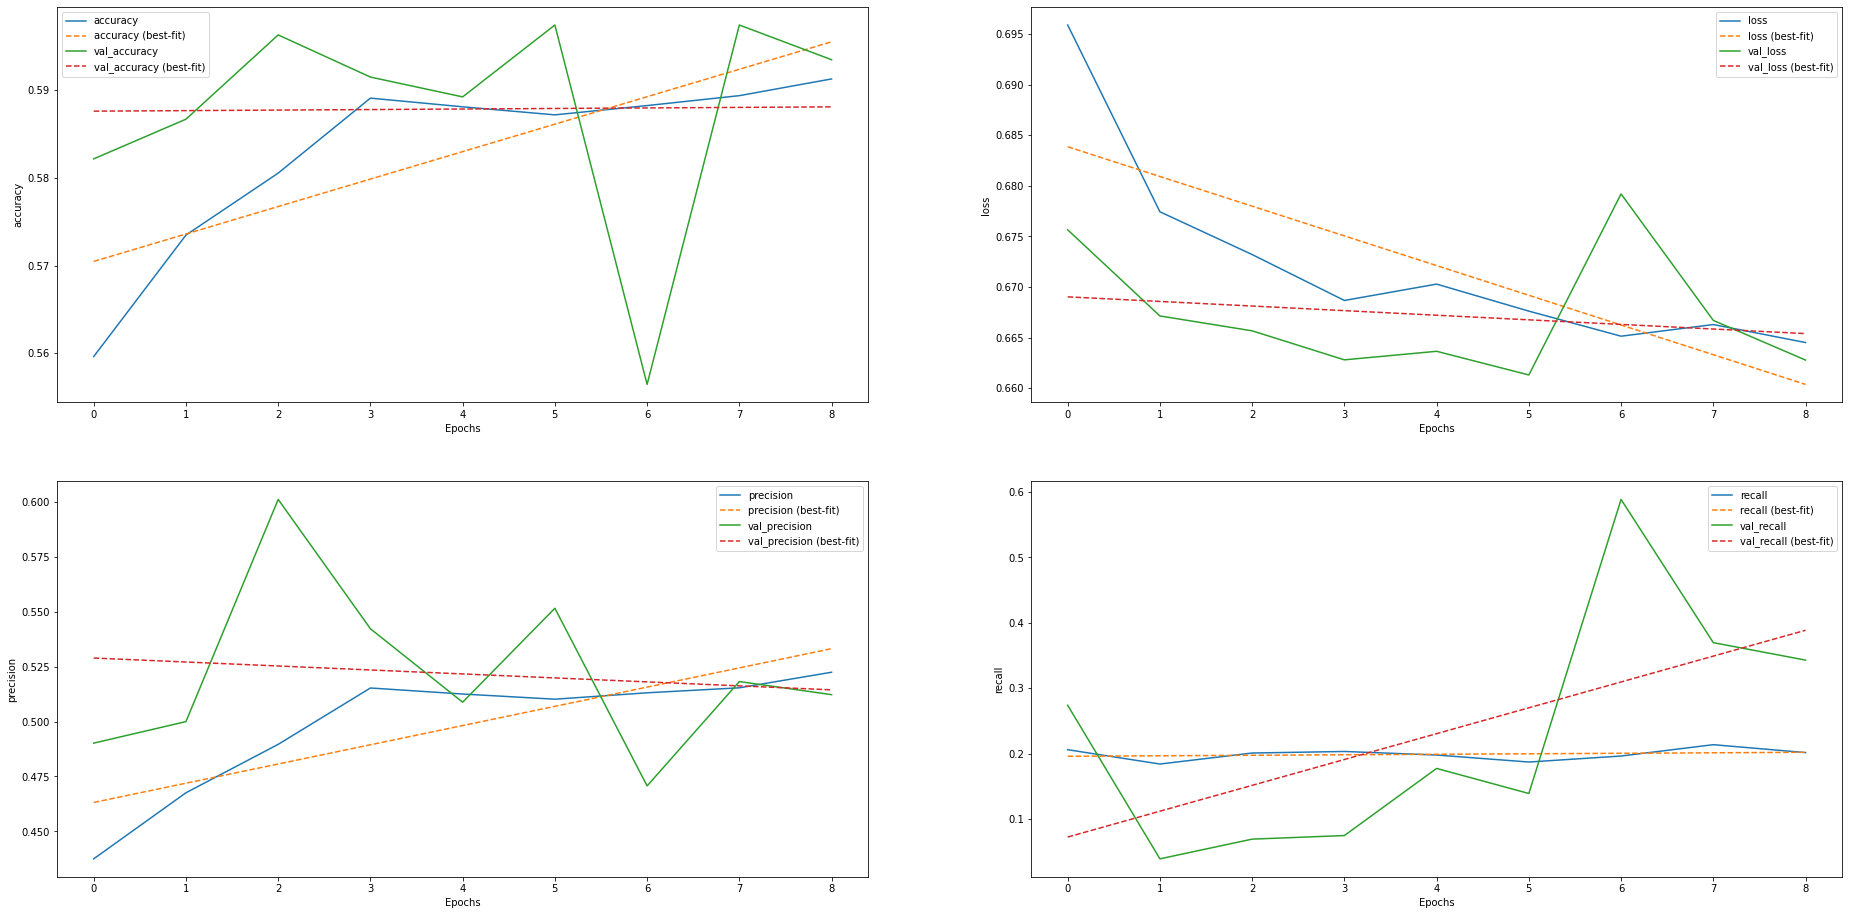

In [11]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    y = history.history[metric]
    y_val = history.history['val_'+metric]
    x = [i for i in range(len(y))]
    
    # m, b = np.polyfit(x, y, 1)
    # m_val, b_val = np.polyfit(x, y_val, 1)

    plt.plot(y)
    plt.plot(x, np.poly1d(np.poly1d(np.polyfit(x, y, 1))(x)), '--')
    plt.plot(y_val, '')
    plt.plot(x, np.poly1d(np.poly1d(np.polyfit(x, y_val, 1))(x)), '--')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'{metric} (best-fit)', 'val_'+metric, f'val_{metric} (best-fit)'])

plt.figure(figsize=(32, 16))
plt.subplot(2, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(2, 2, 2)
plot_graphs(history, 'loss')
plt.subplot(2, 2, 3)
plot_graphs(history, 'precision')
plt.subplot(2, 2, 4)
plot_graphs(history, 'recall')

plt.savefig(graph_save_location)

## Evaluation

In [12]:
model.evaluate(x_test, y_test)

237/237 [==============================] - 79s 334ms/step - loss: 0.6592 - accuracy: 0.5999 - precision: 0.5269 - recall: 0.3607


[0.6591720581054688,
 0.5998679995536804,
 0.5269266366958618,
 0.36066094040870667]

In [13]:
y_true = np.array(y_test.tolist())
y_pred = model.predict(x_test).flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)   # Change values into 1s or 0s

Create confusion matrix

Text(33.0, 0.5, 'Truth')

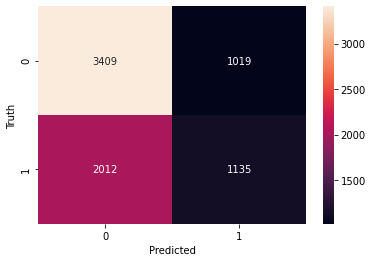

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn

cm = confusion_matrix(y_true, y_pred)

sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.77      0.69      4428
           1       0.53      0.36      0.43      3147

    accuracy                           0.60      7575
   macro avg       0.58      0.57      0.56      7575
weighted avg       0.59      0.60      0.58      7575



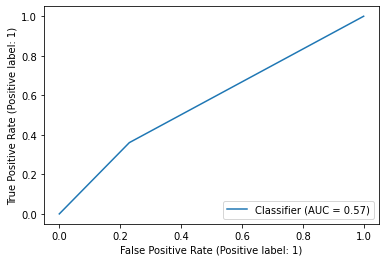

In [16]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_true, y_pred)